In [16]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane-sf
# from google.colab import drive
# drive.mount('/content/drive')

Function fitting with a photonic quantum neural network {#quantum_neural_net}
=======================================================

::: {.meta}
:property=\"og:description\": Fit to noisy data with a variational
quantum circuit. :property=\"og:image\":
<https://pennylane.ai/qml/_images/qnn_output_28_0.png>
:::

::: {.related}
qonn Optimizing a quantum optical neural network pytorch\_noise PyTorch
and noisy devices tutorial\_noisy\_circuit\_optimization Optimizing
noisy circuits with Cirq
:::

*Author: Maria Schuld --- Posted: 11 October 2019. Last updated: 25
January 2021.*

::: {.warning}
::: {.title}
Warning
:::

This demo is only compatible with PennyLane version `0.29` or below.
:::

In this example we show how a variational circuit can be used to learn a
fit for a one-dimensional function when being trained with noisy samples
from that function.

The variational circuit we use is the continuous-variable quantum neural
network model described in [Killoran et al.
(2018)](https://arxiv.org/abs/1806.06871).

Imports
-------

We import PennyLane, the wrapped version of NumPy provided by PennyLane,
and an optimizer.


In [17]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with
only one quantum mode (or `wire`). You will need to have the Strawberry
Fields plugin for PennyLane installed.


In [18]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=15)

Quantum node
============

For a single quantum mode, each layer of the variational circuit is
defined as:


In [19]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.


In [20]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

Objective
=========

As an objective we take the square loss between target labels and model
predictions.


In [21]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).


In [22]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

Optimization
============

We load noisy data samples of a sine function from the external file
`sine.txt`
(`<a href="https://raw.githubusercontent.com/XanaduAI/pennylane/v0.3.0/examples/data/sine.txt"
download="sine.txt" target="_blank">download the file here</a>`{.interpreted-text
role="html"}).


In [23]:
data = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/data/sine.txt")
X = np.array(data[:, 0], requires_grad=False)
Y = np.array(data[:, 1], requires_grad=False)

Before training a model, let\'s examine the data.

*Note: For the next cell to work you need the matplotlib library.*


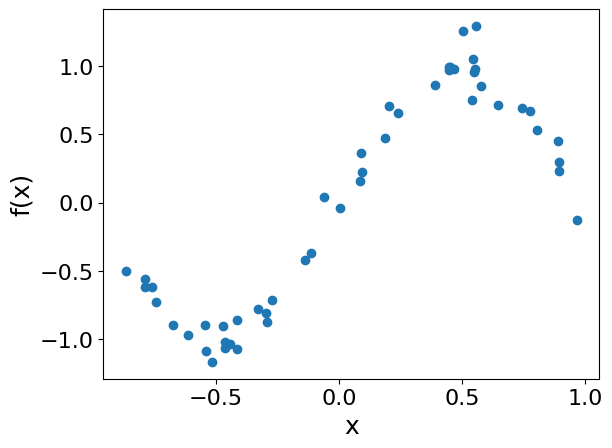

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

![image](../demonstrations/quantum_neural_net/qnn_output_20_0.png)

The network's weights (called `var` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.


In [25]:
np.random.seed(0)
num_layers = 6
var_init = 0.05 * np.random.randn(num_layers, 5, requires_grad=True)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]
 [-0.12764949  0.03268093  0.04322181 -0.03710825  0.11348773]
 [-0.07271828  0.00228793 -0.00935919  0.07663896  0.07346794]]


::: {.rst-class}
sphx-glr-script-out

Out:

``` {.none}
array([[ 0.08820262,  0.02000786,  0.0489369 ,  0.11204466,  0.0933779 ],
       [-0.04886389,  0.04750442, -0.00756786, -0.00516094,  0.02052993],
       [ 0.00720218,  0.07271368,  0.03805189,  0.00608375,  0.02219316],
       [ 0.01668372,  0.07470395, -0.01025791,  0.01565339, -0.04270479]])
```
:::

Using the Adam optimizer, we update the weights for 500 steps (this
takes some time). More steps will lead to a better fit.


In [26]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(500):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X, Y)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost.item()))

Iter:     0 | Cost: 0.1953591 
Iter:     1 | Cost: 0.1760630 
Iter:     2 | Cost: 0.1280265 
Iter:     3 | Cost: 0.1033294 
Iter:     4 | Cost: 0.1076633 
Iter:     5 | Cost: 0.1139029 
Iter:     6 | Cost: 0.1083542 
Iter:     7 | Cost: 0.0949943 
Iter:     8 | Cost: 0.0832784 
Iter:     9 | Cost: 0.0767903 
Iter:    10 | Cost: 0.0712995 
Iter:    11 | Cost: 0.0637771 
Iter:    12 | Cost: 0.0566462 
Iter:    13 | Cost: 0.0534050 
Iter:    14 | Cost: 0.0541692 
Iter:    15 | Cost: 0.0555957 
Iter:    16 | Cost: 0.0545832 
Iter:    17 | Cost: 0.0511300 
Iter:    18 | Cost: 0.0473931 
Iter:    19 | Cost: 0.0449718 
Iter:    20 | Cost: 0.0435704 
Iter:    21 | Cost: 0.0420049 
Iter:    22 | Cost: 0.0398776 
Iter:    23 | Cost: 0.0379477 
Iter:    24 | Cost: 0.0371379 
Iter:    25 | Cost: 0.0374116 
Iter:    26 | Cost: 0.0377261 
Iter:    27 | Cost: 0.0371878 
Iter:    28 | Cost: 0.0359989 
Iter:    29 | Cost: 0.0349924 
Iter:    30 | Cost: 0.0344678 
Iter:    31 | Cost: 0.0338852 
Iter:   

::: {.rst-class}
sphx-glr-script-out

Out:

``` {.none}
Iter:     0 | Cost: 0.3006065
Iter:     1 | Cost: 0.2689702
Iter:     2 | Cost: 0.2472125
Iter:     3 | Cost: 0.2300139
Iter:     4 | Cost: 0.2157100
Iter:     5 | Cost: 0.2035455
Iter:     6 | Cost: 0.1931103
Iter:     7 | Cost: 0.1841536
Iter:     8 | Cost: 0.1765061
Iter:     9 | Cost: 0.1700410
Iter:    10 | Cost: 0.1646527
Iter:    11 | Cost: 0.1602444
Iter:    12 | Cost: 0.1567201
Iter:    13 | Cost: 0.1539806
Iter:    14 | Cost: 0.1519220
Iter:    15 | Cost: 0.1504356
Iter:    16 | Cost: 0.1494099
Iter:    17 | Cost: 0.1487330
Iter:    18 | Cost: 0.1482962
Iter:    19 | Cost: 0.1479980
Iter:    20 | Cost: 0.1477470
Iter:    21 | Cost: 0.1474655
Iter:    22 | Cost: 0.1470914
Iter:    23 | Cost: 0.1465799
Iter:    24 | Cost: 0.1459034
Iter:    25 | Cost: 0.1450506
Iter:    26 | Cost: 0.1440251
Iter:    27 | Cost: 0.1428427
Iter:    28 | Cost: 0.1415282
Iter:    29 | Cost: 0.1401125
Iter:    30 | Cost: 0.1386296
Iter:    31 | Cost: 0.1371132
Iter:    32 | Cost: 0.1355946
Iter:    33 | Cost: 0.1341006
Iter:    34 | Cost: 0.1326526
Iter:    35 | Cost: 0.1312654
Iter:    36 | Cost: 0.1299478
Iter:    37 | Cost: 0.1287022
Iter:    38 | Cost: 0.1275259
Iter:    39 | Cost: 0.1264120
Iter:    40 | Cost: 0.1253502
Iter:    41 | Cost: 0.1243284
Iter:    42 | Cost: 0.1233333
Iter:    43 | Cost: 0.1223521
Iter:    44 | Cost: 0.1213726
Iter:    45 | Cost: 0.1203843
Iter:    46 | Cost: 0.1193790
Iter:    47 | Cost: 0.1183506
Iter:    48 | Cost: 0.1172959
Iter:    49 | Cost: 0.1162138
Iter:    50 | Cost: 0.1151057
Iter:    51 | Cost: 0.1139748
Iter:    52 | Cost: 0.1128259
Iter:    53 | Cost: 0.1116647
Iter:    54 | Cost: 0.1104972
Iter:    55 | Cost: 0.1093295
Iter:    56 | Cost: 0.1081673
Iter:    57 | Cost: 0.1070151
Iter:    58 | Cost: 0.1058764
Iter:    59 | Cost: 0.1047533
Iter:    60 | Cost: 0.1036464
Iter:    61 | Cost: 0.1025554
Iter:    62 | Cost: 0.1014787
Iter:    63 | Cost: 0.1004141
Iter:    64 | Cost: 0.0993591
Iter:    65 | Cost: 0.0983111
Iter:    66 | Cost: 0.0972679
Iter:    67 | Cost: 0.0962278
Iter:    68 | Cost: 0.0951896
Iter:    69 | Cost: 0.0941534
Iter:    70 | Cost: 0.0931195
Iter:    71 | Cost: 0.0920891
Iter:    72 | Cost: 0.0910638
Iter:    73 | Cost: 0.0900453
Iter:    74 | Cost: 0.0890357
Iter:    75 | Cost: 0.0880366
Iter:    76 | Cost: 0.0870493
Iter:    77 | Cost: 0.0860751
Iter:    78 | Cost: 0.0851144
Iter:    79 | Cost: 0.0841675
Iter:    80 | Cost: 0.0832342
Iter:    81 | Cost: 0.0823143
Iter:    82 | Cost: 0.0814072
Iter:    83 | Cost: 0.0805125
Iter:    84 | Cost: 0.0796296
Iter:    85 | Cost: 0.0787583
Iter:    86 | Cost: 0.0778983
Iter:    87 | Cost: 0.0770497
Iter:    88 | Cost: 0.0762127
Iter:    89 | Cost: 0.0753874
Iter:    90 | Cost: 0.0745742
Iter:    91 | Cost: 0.0737733
Iter:    92 | Cost: 0.0729849
Iter:    93 | Cost: 0.0722092
Iter:    94 | Cost: 0.0714462
Iter:    95 | Cost: 0.0706958
Iter:    96 | Cost: 0.0699578
Iter:    97 | Cost: 0.0692319
Iter:    98 | Cost: 0.0685177
Iter:    99 | Cost: 0.0678151
Iter:   100 | Cost: 0.0671236
Iter:   101 | Cost: 0.0664430
Iter:   102 | Cost: 0.0657732
Iter:   103 | Cost: 0.0651139
Iter:   104 | Cost: 0.0644650
Iter:   105 | Cost: 0.0638264
Iter:   106 | Cost: 0.0631981
Iter:   107 | Cost: 0.0625800
Iter:   108 | Cost: 0.0619719
Iter:   109 | Cost: 0.0613737
Iter:   110 | Cost: 0.0607853
Iter:   111 | Cost: 0.0602064
Iter:   112 | Cost: 0.0596368
Iter:   113 | Cost: 0.0590764
Iter:   114 | Cost: 0.0585249
Iter:   115 | Cost: 0.0579820
Iter:   116 | Cost: 0.0574476
Iter:   117 | Cost: 0.0569214
Iter:   118 | Cost: 0.0564033
Iter:   119 | Cost: 0.0558932
Iter:   120 | Cost: 0.0553908
Iter:   121 | Cost: 0.0548960
Iter:   122 | Cost: 0.0544086
Iter:   123 | Cost: 0.0539286
Iter:   124 | Cost: 0.0534557
Iter:   125 | Cost: 0.0529897
Iter:   126 | Cost: 0.0525306
Iter:   127 | Cost: 0.0520781
Iter:   128 | Cost: 0.0516320
Iter:   129 | Cost: 0.0511923
Iter:   130 | Cost: 0.0507587
Iter:   131 | Cost: 0.0503311
Iter:   132 | Cost: 0.0499094
Iter:   133 | Cost: 0.0494934
Iter:   134 | Cost: 0.0490830
Iter:   135 | Cost: 0.0486781
Iter:   136 | Cost: 0.0482785
Iter:   137 | Cost: 0.0478842
Iter:   138 | Cost: 0.0474949
Iter:   139 | Cost: 0.0471107
Iter:   140 | Cost: 0.0467313
Iter:   141 | Cost: 0.0463567
Iter:   142 | Cost: 0.0459868
Iter:   143 | Cost: 0.0456214
Iter:   144 | Cost: 0.0452604
Iter:   145 | Cost: 0.0449038
Iter:   146 | Cost: 0.0445514
Iter:   147 | Cost: 0.0442032
Iter:   148 | Cost: 0.0438590
Iter:   149 | Cost: 0.0435188
Iter:   150 | Cost: 0.0431825
Iter:   151 | Cost: 0.0428499
Iter:   152 | Cost: 0.0425211
Iter:   153 | Cost: 0.0421960
Iter:   154 | Cost: 0.0418744
Iter:   155 | Cost: 0.0415563
Iter:   156 | Cost: 0.0412416
Iter:   157 | Cost: 0.0409302
Iter:   158 | Cost: 0.0406222
Iter:   159 | Cost: 0.0403173
Iter:   160 | Cost: 0.0400156
Iter:   161 | Cost: 0.0397169
Iter:   162 | Cost: 0.0394213
Iter:   163 | Cost: 0.0391286
Iter:   164 | Cost: 0.0388389
Iter:   165 | Cost: 0.0385520
Iter:   166 | Cost: 0.0382679
Iter:   167 | Cost: 0.0379866
Iter:   168 | Cost: 0.0377079
Iter:   169 | Cost: 0.0374319
Iter:   170 | Cost: 0.0371585
Iter:   171 | Cost: 0.0368877
Iter:   172 | Cost: 0.0366194
Iter:   173 | Cost: 0.0363535
Iter:   174 | Cost: 0.0360901
Iter:   175 | Cost: 0.0358291
Iter:   176 | Cost: 0.0355704
Iter:   177 | Cost: 0.0353140
Iter:   178 | Cost: 0.0350599
Iter:   179 | Cost: 0.0348081
Iter:   180 | Cost: 0.0345585
Iter:   181 | Cost: 0.0343110
Iter:   182 | Cost: 0.0340658
Iter:   183 | Cost: 0.0338226
Iter:   184 | Cost: 0.0335815
Iter:   185 | Cost: 0.0333425
Iter:   186 | Cost: 0.0331056
Iter:   187 | Cost: 0.0328706
Iter:   188 | Cost: 0.0326377
Iter:   189 | Cost: 0.0324067
Iter:   190 | Cost: 0.0321777
Iter:   191 | Cost: 0.0319506
Iter:   192 | Cost: 0.0317255
Iter:   193 | Cost: 0.0315022
Iter:   194 | Cost: 0.0312808
Iter:   195 | Cost: 0.0310613
Iter:   196 | Cost: 0.0308436
Iter:   197 | Cost: 0.0306278
Iter:   198 | Cost: 0.0304138
Iter:   199 | Cost: 0.0302016
Iter:   200 | Cost: 0.0299912
Iter:   201 | Cost: 0.0297826
Iter:   202 | Cost: 0.0295757
Iter:   203 | Cost: 0.0293707
Iter:   204 | Cost: 0.0291674
Iter:   205 | Cost: 0.0289659
Iter:   206 | Cost: 0.0287661
Iter:   207 | Cost: 0.0285681
Iter:   208 | Cost: 0.0283718
Iter:   209 | Cost: 0.0281772
Iter:   210 | Cost: 0.0279844
Iter:   211 | Cost: 0.0277933
Iter:   212 | Cost: 0.0276039
Iter:   213 | Cost: 0.0274163
Iter:   214 | Cost: 0.0272304
Iter:   215 | Cost: 0.0270461
Iter:   216 | Cost: 0.0268636
Iter:   217 | Cost: 0.0266829
Iter:   218 | Cost: 0.0265038
Iter:   219 | Cost: 0.0263264
Iter:   220 | Cost: 0.0261508
Iter:   221 | Cost: 0.0259768
Iter:   222 | Cost: 0.0258046
Iter:   223 | Cost: 0.0256341
Iter:   224 | Cost: 0.0254652
Iter:   225 | Cost: 0.0252981
Iter:   226 | Cost: 0.0251327
Iter:   227 | Cost: 0.0249690
Iter:   228 | Cost: 0.0248070
Iter:   229 | Cost: 0.0246467
Iter:   230 | Cost: 0.0244881
Iter:   231 | Cost: 0.0243312
Iter:   232 | Cost: 0.0241760
Iter:   233 | Cost: 0.0240225
Iter:   234 | Cost: 0.0238707
Iter:   235 | Cost: 0.0237206
Iter:   236 | Cost: 0.0235721
Iter:   237 | Cost: 0.0234254
Iter:   238 | Cost: 0.0232803
Iter:   239 | Cost: 0.0231369
Iter:   240 | Cost: 0.0229952
Iter:   241 | Cost: 0.0228552
Iter:   242 | Cost: 0.0227168
Iter:   243 | Cost: 0.0225801
Iter:   244 | Cost: 0.0224450
Iter:   245 | Cost: 0.0223116
Iter:   246 | Cost: 0.0221798
Iter:   247 | Cost: 0.0220496
Iter:   248 | Cost: 0.0219211
Iter:   249 | Cost: 0.0217942
Iter:   250 | Cost: 0.0216688
Iter:   251 | Cost: 0.0215451
Iter:   252 | Cost: 0.0214230
Iter:   253 | Cost: 0.0213024
Iter:   254 | Cost: 0.0211835
Iter:   255 | Cost: 0.0210660
Iter:   256 | Cost: 0.0209502
Iter:   257 | Cost: 0.0208358
Iter:   258 | Cost: 0.0207230
Iter:   259 | Cost: 0.0206117
Iter:   260 | Cost: 0.0205019
Iter:   261 | Cost: 0.0203936
Iter:   262 | Cost: 0.0202867
Iter:   263 | Cost: 0.0201813
Iter:   264 | Cost: 0.0200773
Iter:   265 | Cost: 0.0199748
Iter:   266 | Cost: 0.0198737
Iter:   267 | Cost: 0.0197740
Iter:   268 | Cost: 0.0196757
Iter:   269 | Cost: 0.0195787
Iter:   270 | Cost: 0.0194831
Iter:   271 | Cost: 0.0193889
Iter:   272 | Cost: 0.0192959
Iter:   273 | Cost: 0.0192043
Iter:   274 | Cost: 0.0191140
Iter:   275 | Cost: 0.0190249
Iter:   276 | Cost: 0.0189371
Iter:   277 | Cost: 0.0188505
Iter:   278 | Cost: 0.0187651
Iter:   279 | Cost: 0.0186810
Iter:   280 | Cost: 0.0185980
Iter:   281 | Cost: 0.0185163
Iter:   282 | Cost: 0.0184356
Iter:   283 | Cost: 0.0183561
Iter:   284 | Cost: 0.0182777
Iter:   285 | Cost: 0.0182004
Iter:   286 | Cost: 0.0181242
Iter:   287 | Cost: 0.0180491
Iter:   288 | Cost: 0.0179750
Iter:   289 | Cost: 0.0179020
Iter:   290 | Cost: 0.0178299
Iter:   291 | Cost: 0.0177589
Iter:   292 | Cost: 0.0176888
Iter:   293 | Cost: 0.0176197
Iter:   294 | Cost: 0.0175515
Iter:   295 | Cost: 0.0174843
Iter:   296 | Cost: 0.0174180
Iter:   297 | Cost: 0.0173525
Iter:   298 | Cost: 0.0172880
Iter:   299 | Cost: 0.0172243
Iter:   300 | Cost: 0.0171614
Iter:   301 | Cost: 0.0170994
Iter:   302 | Cost: 0.0170382
Iter:   303 | Cost: 0.0169777
Iter:   304 | Cost: 0.0169181
Iter:   305 | Cost: 0.0168592
Iter:   306 | Cost: 0.0168010
Iter:   307 | Cost: 0.0167436
Iter:   308 | Cost: 0.0166869
Iter:   309 | Cost: 0.0166309
Iter:   310 | Cost: 0.0165756
Iter:   311 | Cost: 0.0165209
Iter:   312 | Cost: 0.0164669
Iter:   313 | Cost: 0.0164136
Iter:   314 | Cost: 0.0163608
Iter:   315 | Cost: 0.0163087
Iter:   316 | Cost: 0.0162572
Iter:   317 | Cost: 0.0162063
Iter:   318 | Cost: 0.0161559
Iter:   319 | Cost: 0.0161061
Iter:   320 | Cost: 0.0160568
Iter:   321 | Cost: 0.0160080
Iter:   322 | Cost: 0.0159598
Iter:   323 | Cost: 0.0159121
Iter:   324 | Cost: 0.0158649
Iter:   325 | Cost: 0.0158181
Iter:   326 | Cost: 0.0157719
Iter:   327 | Cost: 0.0157260
Iter:   328 | Cost: 0.0156807
Iter:   329 | Cost: 0.0156357
Iter:   330 | Cost: 0.0155912
Iter:   331 | Cost: 0.0155471
Iter:   332 | Cost: 0.0155034
Iter:   333 | Cost: 0.0154601
Iter:   334 | Cost: 0.0154172
Iter:   335 | Cost: 0.0153747
Iter:   336 | Cost: 0.0153325
Iter:   337 | Cost: 0.0152907
Iter:   338 | Cost: 0.0152492
Iter:   339 | Cost: 0.0152081
Iter:   340 | Cost: 0.0151673
Iter:   341 | Cost: 0.0151269
Iter:   342 | Cost: 0.0150867
Iter:   343 | Cost: 0.0150469
Iter:   344 | Cost: 0.0150073
Iter:   345 | Cost: 0.0149681
Iter:   346 | Cost: 0.0149291
Iter:   347 | Cost: 0.0148905
Iter:   348 | Cost: 0.0148521
Iter:   349 | Cost: 0.0148140
Iter:   350 | Cost: 0.0147761
Iter:   351 | Cost: 0.0147385
Iter:   352 | Cost: 0.0147012
Iter:   353 | Cost: 0.0146641
Iter:   354 | Cost: 0.0146273
Iter:   355 | Cost: 0.0145907
Iter:   356 | Cost: 0.0145543
Iter:   357 | Cost: 0.0145182
Iter:   358 | Cost: 0.0144824
Iter:   359 | Cost: 0.0144467
Iter:   360 | Cost: 0.0144113
Iter:   361 | Cost: 0.0143762
Iter:   362 | Cost: 0.0143412
Iter:   363 | Cost: 0.0143065
Iter:   364 | Cost: 0.0142720
Iter:   365 | Cost: 0.0142378
Iter:   366 | Cost: 0.0142037
Iter:   367 | Cost: 0.0141699
Iter:   368 | Cost: 0.0141363
Iter:   369 | Cost: 0.0141030
Iter:   370 | Cost: 0.0140699
Iter:   371 | Cost: 0.0140370
Iter:   372 | Cost: 0.0140043
Iter:   373 | Cost: 0.0139719
Iter:   374 | Cost: 0.0139397
Iter:   375 | Cost: 0.0139077
Iter:   376 | Cost: 0.0138760
Iter:   377 | Cost: 0.0138445
Iter:   378 | Cost: 0.0138132
Iter:   379 | Cost: 0.0137822
Iter:   380 | Cost: 0.0137515
Iter:   381 | Cost: 0.0137210
Iter:   382 | Cost: 0.0136907
Iter:   383 | Cost: 0.0136607
Iter:   384 | Cost: 0.0136310
Iter:   385 | Cost: 0.0136015
Iter:   386 | Cost: 0.0135723
Iter:   387 | Cost: 0.0135433
Iter:   388 | Cost: 0.0135146
Iter:   389 | Cost: 0.0134863
Iter:   390 | Cost: 0.0134581
Iter:   391 | Cost: 0.0134303
Iter:   392 | Cost: 0.0134027
Iter:   393 | Cost: 0.0133755
Iter:   394 | Cost: 0.0133485
Iter:   395 | Cost: 0.0133218
Iter:   396 | Cost: 0.0132954
Iter:   397 | Cost: 0.0132694
Iter:   398 | Cost: 0.0132436
Iter:   399 | Cost: 0.0132181
Iter:   400 | Cost: 0.0131929
Iter:   401 | Cost: 0.0131681
Iter:   402 | Cost: 0.0131435
Iter:   403 | Cost: 0.0131193
Iter:   404 | Cost: 0.0130953
Iter:   405 | Cost: 0.0130717
Iter:   406 | Cost: 0.0130484
Iter:   407 | Cost: 0.0130254
Iter:   408 | Cost: 0.0130028
Iter:   409 | Cost: 0.0129804
Iter:   410 | Cost: 0.0129584
Iter:   411 | Cost: 0.0129367
Iter:   412 | Cost: 0.0129153
Iter:   413 | Cost: 0.0128942
Iter:   414 | Cost: 0.0128735
Iter:   415 | Cost: 0.0128530
Iter:   416 | Cost: 0.0128329
Iter:   417 | Cost: 0.0128131
Iter:   418 | Cost: 0.0127935
Iter:   419 | Cost: 0.0127743
Iter:   420 | Cost: 0.0127554
Iter:   421 | Cost: 0.0127368
Iter:   422 | Cost: 0.0127185
Iter:   423 | Cost: 0.0127006
Iter:   424 | Cost: 0.0126829
Iter:   425 | Cost: 0.0126655
Iter:   426 | Cost: 0.0126483
Iter:   427 | Cost: 0.0126315
Iter:   428 | Cost: 0.0126150
Iter:   429 | Cost: 0.0125987
Iter:   430 | Cost: 0.0125827
Iter:   431 | Cost: 0.0125670
Iter:   432 | Cost: 0.0125516
Iter:   433 | Cost: 0.0125364
Iter:   434 | Cost: 0.0125215
Iter:   435 | Cost: 0.0125068
Iter:   436 | Cost: 0.0124924
Iter:   437 | Cost: 0.0124782
Iter:   438 | Cost: 0.0124643
Iter:   439 | Cost: 0.0124507
Iter:   440 | Cost: 0.0124372
Iter:   441 | Cost: 0.0124240
Iter:   442 | Cost: 0.0124110
Iter:   443 | Cost: 0.0123983
Iter:   444 | Cost: 0.0123857
Iter:   445 | Cost: 0.0123734
Iter:   446 | Cost: 0.0123613
Iter:   447 | Cost: 0.0123494
Iter:   448 | Cost: 0.0123377
Iter:   449 | Cost: 0.0123262
Iter:   450 | Cost: 0.0123149
Iter:   451 | Cost: 0.0123038
Iter:   452 | Cost: 0.0122929
Iter:   453 | Cost: 0.0122821
Iter:   454 | Cost: 0.0122715
Iter:   455 | Cost: 0.0122611
Iter:   456 | Cost: 0.0122509
Iter:   457 | Cost: 0.0122409
Iter:   458 | Cost: 0.0122310
Iter:   459 | Cost: 0.0122212
Iter:   460 | Cost: 0.0122116
Iter:   461 | Cost: 0.0122022
Iter:   462 | Cost: 0.0121929
Iter:   463 | Cost: 0.0121838
Iter:   464 | Cost: 0.0121748
Iter:   465 | Cost: 0.0121660
Iter:   466 | Cost: 0.0121572
Iter:   467 | Cost: 0.0121487
Iter:   468 | Cost: 0.0121402
Iter:   469 | Cost: 0.0121319
Iter:   470 | Cost: 0.0121237
Iter:   471 | Cost: 0.0121156
Iter:   472 | Cost: 0.0121076
Iter:   473 | Cost: 0.0120998
Iter:   474 | Cost: 0.0120921
Iter:   475 | Cost: 0.0120844
Iter:   476 | Cost: 0.0120769
Iter:   477 | Cost: 0.0120695
Iter:   478 | Cost: 0.0120622
Iter:   479 | Cost: 0.0120550
Iter:   480 | Cost: 0.0120479
Iter:   481 | Cost: 0.0120409
Iter:   482 | Cost: 0.0120340
Iter:   483 | Cost: 0.0120272
Iter:   484 | Cost: 0.0120205
Iter:   485 | Cost: 0.0120138
Iter:   486 | Cost: 0.0120073
Iter:   487 | Cost: 0.0120008
Iter:   488 | Cost: 0.0119944
Iter:   489 | Cost: 0.0119881
Iter:   490 | Cost: 0.0119819
Iter:   491 | Cost: 0.0119758
Iter:   492 | Cost: 0.0119697
Iter:   493 | Cost: 0.0119637
Iter:   494 | Cost: 0.0119578
Iter:   495 | Cost: 0.0119520
Iter:   496 | Cost: 0.0119462
Iter:   497 | Cost: 0.0119405
Iter:   498 | Cost: 0.0119349
Iter:   499 | Cost: 0.0119293
```
:::

Finally, we collect the predictions of the trained model for 50 values
in the range $[-1,1]$:


In [27]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x_) for x_ in x_pred]

and plot the shape of the function that the model has "learned" from the
noisy data (green dots).


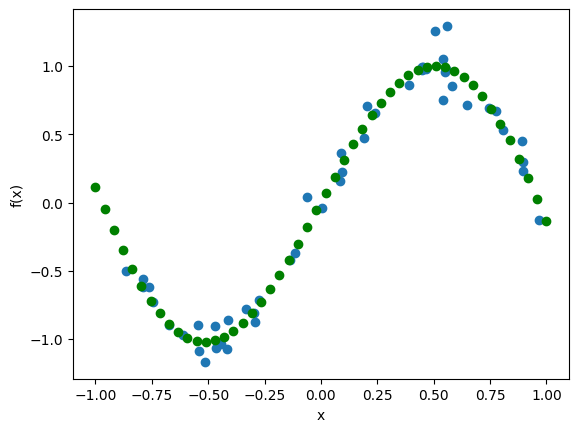

In [28]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

![image](../demonstrations/quantum_neural_net/qnn_output_28_0.png)

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, the more layers, the smaller
the period).


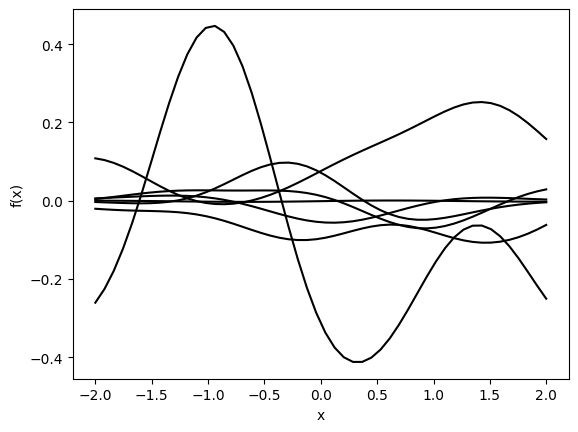

In [29]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

![image](../demonstrations/quantum_neural_net/qnn_output_30_0.png)


About the author
================
